In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
xr.set_options(keep_attrs=True)
import sys
import my_utils as myf
import matplotlib.path as mpath
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
# need env22 for cartopy!

In [2]:
mydir = '/glade/work/lettier/archived_data/202212_data_paper_nudge_winds_amoc/UV_corrERAI_2004-2016/'
myfiles = [f for f in sorted(os.listdir(mydir)) if '.nc' in f]
atl_avg_26 = []
listds = []
for f in myfiles:
    ds = xr.open_dataset(mydir+f)
    atl_avg_26.append(ds.isel(lat=124).where(ds.lon>285).where(ds.lon<340).mean(dim='lon'))
    listds.append(ds)
ds = xr.concat(listds,dim='names')
atl_avg_26 = xr.concat(atl_avg_26,dim='names')

In [3]:
garea, _, _ = myf.grid_area_regll(ds.lat,ds.lon)
tarea = xr.DataArray(garea, dims=['lat','lon'], coords = {'lat':ds.lat,'lon':ds.lon})

def gavg(da):
    return (da*tarea).sum(dim=['lat','lon'])/(tarea).sum(dim=['lat','lon'])

In [4]:
lineplotprop = myf.set_line_prop(ds.names.values)

In [5]:
mylabels = [lineplotprop[f]['label'] for f in lineplotprop[:]]
mylabels = list(set(mylabels))

In [6]:
mylabels = [ 'NUDGE-ERAI-SH (45-90S)',
 'aNUDGE-ERAI-60 (60-90N and 60-90S)',
 'NUDGE-ERAI (45-60N)',
 'NUDGE-ERAI (45-90N)',
 'NUDGE-ERAI (45-90N and 45-90S)',
 'aNUDGE-ERAI (45-90N and 45-90S)',
 'NUDGE-ERA5']

In [7]:
mymasks = [tarea.where(tarea.lat>-45),
           tarea.where(abs(tarea.lat)<60),
           tarea.where(tarea.lat<45,0.) + tarea.where(tarea.lat>60,0.),
           tarea.where(tarea.lat<45),
           tarea.where(abs(tarea.lat)<45),
           tarea.where(abs(tarea.lat)<45),
           tarea.where(abs(tarea.lat)<45),]

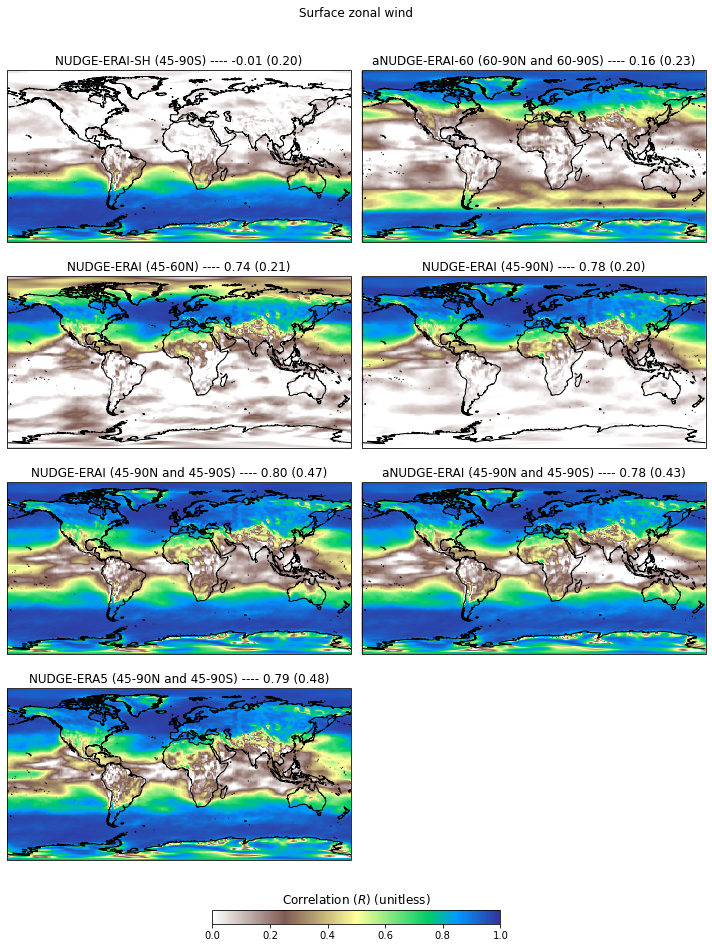

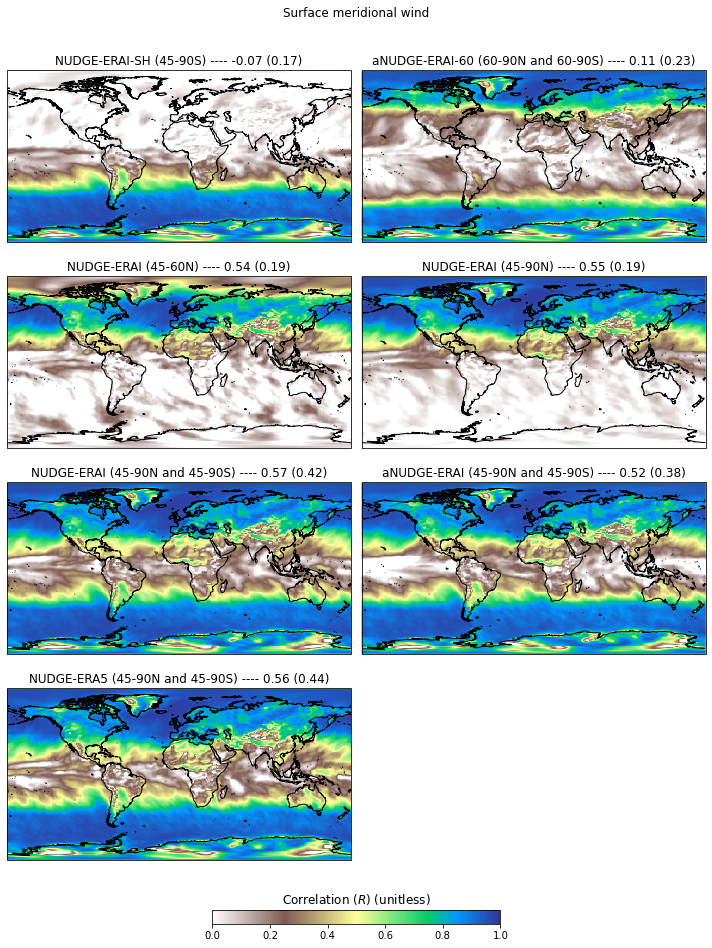

In [8]:
varlabels = ['Surface zonal wind','Surface meridional wind']
for v, var in enumerate(['U','V']):

    fig = plt.figure(figsize=(10,13))
    for l, label in enumerate(mylabels):
        ax = plt.subplot(4,2,1+l, projection = ccrs.PlateCarree(central_longitude=0.))

        mynames = [f for f in ds.names.values if lineplotprop[f]['label']==label]


        mydata = ds.isel(lev=-1)[var+'_corr'].sel(names=mynames).mean(dim='names')
        
        mymask = mymasks[l].where(mymasks[l]>0)
        nonloc = (ds.isel(lev=-1)[var+'_corr'].sel(names=mynames)*mymask).sum(dim=['lat','lon'])/(mymask).sum(dim=['lat','lon'])
        nonloc = nonloc.mean(dim='names')
        atldata = atl_avg_26.isel(lev=-1)[var+'_corr'].sel(names=mynames).mean(dim='names')
        pl = mydata.plot(ax=ax,vmin=0,vmax=1, cmap = plt.cm.terrain_r, transform=ccrs.PlateCarree(),add_colorbar=False)
        ax.coastlines('50m')
        if 'ERA5' in label:
            ax.set_title(label+' (45-90N and 45-90S) ---- {:.2f} ({:.2f})'.format(atldata.values,nonloc.values))# Atlantic-average, 26N=
        else:
            ax.set_title(label+' ---- {:.2f} ({:.2f})'.format(atldata.values,nonloc.values))# Atlantic-average, 26N=

    plt.tight_layout()
    plt.subplots_adjust(bottom = .05, top=0.93)
    cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.015]) #[left, bottom, width, height]
    cbar = fig.colorbar(pl, cax=cbar_ax,  orientation='horizontal')
    cbar.ax.set_title('Correlation ($R$) (unitless)',fontsize=12)
    plt.suptitle(varlabels[v],fontsize=12)
    fig.savefig('figs/suppFig'+str(4+v)+'.pdf',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close() 

In [9]:
mydir = '/glade/work/lettier/archived_data/202212_data_paper_nudge_winds_amoc/moc/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if '.nc' in f and ('CESM1FO' not in f)]

listds = []
for f in myfiles:
    ds = xr.open_dataset(f)[['moc_rapid','ekman']].rename({'moc_rapid':'MOC'}).sel(time=slice('2004-02','2017-01'))
    myname = str(f.split('/')[-1].split('natl')[0])[:-15]
    mytime = pd.date_range(start="2004-01-01",end="2016-12-31", freq='M')
    if myname=='CESM1':
        myname = 'CESM1FO'
        mytime = pd.date_range(start="2004-01-01",end="2016-12-31", freq='M')
    ds['time'] = mytime
    ds['names'] = myname
    ds = ds.set_coords('names')
    listds.append(ds)
ds = xr.concat(listds,dim='names')

In [10]:
rapid = xr.open_dataset('/glade/work/lettier/RAPID/MOCv2021/moc_transports_200404_202039.nc')[['moc_mar_hc10','t_ek10']] # this is daily, take monthly average
rapid_mon = rapid.resample(time='1M').mean('time').rename({'moc_mar_hc10':'MOC',
                                                          't_ek10':'ekman'})
rapid_mon['names'] = 'RAPID'
rapid_mon = rapid_mon.set_coords('names')
ds = xr.concat([ds, rapid_mon],dim='names')

In [11]:
obs_data = ds.sel(names='RAPID')
ds_short = ds.where(obs_data.MOC==obs_data.MOC,drop=True).rolling(time=12, center=True).mean()
ds_short = ds_short.where(ds_short==ds_short,drop=True)
trend_short, _, _, pval_short, _ = myf.linregress(np.arange(len(ds_short.time)),ds_short.load(),dim='time')
ds_short_detrended = ds_short - trend_short*xr.DataArray(np.arange(len(ds_short.time)), coords={'time':ds_short.time},dims=('time'))
corr_short, _ = myf.pearson(ds_short_detrended.sel(names='RAPID'),ds_short_detrended,dim='time')

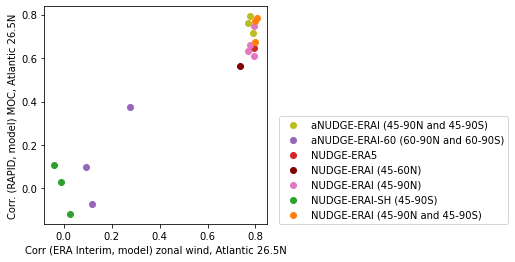

In [12]:
fig, ax = plt.subplots(1,figsize=(4,4))
for name in ds.names.values:
    if name in atl_avg_26.names.values and 'LENS' not in name:
        ax.scatter(atl_avg_26.U_corr.isel(lev=-1).sel(names=name), corr_short.MOC.sel(names=name),
                   label=lineplotprop[name]['label'], c=lineplotprop[name]['c'])

ax.set_xlabel('Corr (ERA Interim, model) zonal wind, Atlantic 26.5N')
ax.set_ylabel('Corr. (RAPID, model) MOC, Atlantic 26.5N')
ax.set_title('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc=(1.05,0))     
plt.show()
plt.tight_layout()
fig.savefig('figs/suppFig6.pdf', dpi=500, bbox_inches='tight')
plt.close()